In [ ]:
# Load data
%cd data
!sh get_data.sh
%cd ..

In [ ]:
%cd content
!ls

/content
data  get_data.sh  sample_data


In [ ]:
import os
import pandas as pd
from PIL import Image
import numpy as np
from collections import Counter
import re

In [ ]:
class Im2LatexDataHandler:
    def __init__(self, data_dir="./data/dataset5"):
        self.data_dir = data_dir
        self.image_dir = os.path.join(data_dir, "formula_images")
        self.training_dir = os.path.join(data_dir, "training_56")
        self.input_data_dir = os.path.join(data_dir, "training_56")
        self.batch_size = 56

    def load_data(self, filename):
        """Load DataFrame from a pickle file."""
        file_path = os.path.join(self.input_data_dir, filename)
        return pd.read_pickle(file_path)

    def load_image(self, image_filename):
        """Load an image file."""
        image_path = os.path.join(self.image_dir, image_filename)
        return Image.open(image_path)

    def load_images_in_batches(self, dataframe):
        """Generator to load images in batches."""
        batch = {}
        for image_filename in dataframe["image"]:
            img = self.load_image(image_filename)
            batch[image_filename] = img
            if len(batch) == self.batch_size:
                yield batch
                batch = {}
        if batch:
            yield batch

    def load_data_and_images(self):
        df_train = self.load_data("df_train.pkl")
        df_valid = self.load_data("df_valid.pkl")
        df_test = self.load_data("df_test.pkl")

        df_train = df_train.drop_duplicates(subset="image", keep="first")
        df_test = df_test.drop_duplicates(subset="image", keep="first")
        df_valid = df_valid.drop_duplicates(subset="image", keep="first")

        df_combined = pd.concat([df_train, df_valid, df_test]).reset_index(drop=True)

        df_combined = df_combined.drop_duplicates(subset="image", keep="first")
        y_combined = {}
        for batch in self.load_images_in_batches(df_combined):
            y_combined.update(batch)

        if not (df_combined.index == range(df_combined.shape[0])).all():
            print("Index is not continuous or does not start from 0.")
            df_combined = df_combined.reset_index(drop=True)
            print("Index after reset:", df_combined.index)

        print(len(df_combined), len(y_combined))

        return df_combined, y_combined

In [ ]:
handler = Im2LatexDataHandler()
df_combined, y_combined = handler.load_data_and_images()

142966 142966


In [ ]:
df_combined.head()

,image,height,width,word2id_len,bin_len,word2id,latex_ascii,padded_seq,padded_seq_len,seq_len,squashed_len,squashed_seq
0,23be72ded29e9b4_basic.png,78,738,112,151,"[163, 305, 334, 11, 145, 336, 304, 334, 162, 3...",\int _ { - \epsilon } ^ { \infty } d l \: \mat...,"[163, 305, 334, 11, 145, 336, 304, 334, 162, 3...",151,113,113,"[163, 305, 334, 11, 145, 336, 304, 334, 162, 3..."
1,8c904c5d9c7bd63_basic.png,94,962,129,151,"[311, 326, 304, 334, 17, 336, 28, 6, 16, 11, 3...",d s ^ { 2 } = ( 1 - { \frac { q c o s \theta }...,"[311, 326, 304, 334, 17, 336, 28, 6, 16, 11, 3...",151,130,130,"[311, 326, 304, 334, 17, 336, 28, 6, 16, 11, 3..."
2,1f111caa1be3516_basic.png,87,291,51,56,"[296, 151, 305, 334, 195, 334, 315, 322, 323, ...",\widetilde \gamma _ { \mathrm { h o p f } } \s...,"[296, 151, 305, 334, 195, 334, 315, 322, 323, ...",56,52,52,"[296, 151, 305, 334, 195, 334, 315, 322, 323, ..."
3,7483d06c1e14dcb_basic.png,60,521,61,65,"[48, 305, 334, 326, 327, 307, 327, 336, 28, 17...",S _ { s t a t } = 2 \pi \sqrt { N _ { 5 } ^ { ...,"[48, 305, 334, 326, 327, 307, 327, 336, 28, 17...",65,62,62,"[48, 305, 334, 326, 327, 307, 327, 336, 28, 17..."
4,1d7098797009973_basic.png,80,817,114,151,"[334, 150, 334, 224, 304, 334, 227, 227, 336, ...",{ \frac { \phi ^ { \prime \prime } } { A } } +...,"[334, 150, 334, 224, 304, 334, 227, 227, 336, ...",151,115,115,"[334, 150, 334, 224, 304, 334, 227, 227, 336, ..."


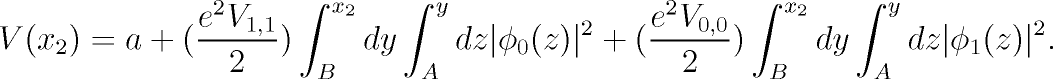

In [ ]:
y_combined['5be77b312bfa0c1_basic.png']

In [ ]:
def calculate_image_statistics(df_combined, y_combined):
      sizes = [(image.size[0], image.size[1]) for image in y_combined.values()]
      widths = [size[0] for size in sizes]
      heights = [size[1] for size in sizes]

      stats = {
          'min_width': np.min(widths),
          'max_width': np.max(widths),
          'mean_width': np.mean(widths),
          'std_width': np.std(widths),
          'min_height': np.min(heights),
          'max_height': np.max(heights),
          'mean_height': np.mean(heights),
          'std_height': np.std(heights),
      }

      return stats

stats = calculate_image_statistics(df_combined, y_combined)
print(stats)

In [ ]:
def calculate_formula_statistics(df_combined):
      formula_lengths = df_combined['latex_ascii'].apply(len)

      stats = {
          'min_length': np.min(formula_lengths),
          'max_length': np.max(formula_lengths),
          'mean_length': np.mean(formula_lengths),
          'std_length': np.std(formula_lengths),
      }

      return stats

stats = calculate_formula_statistics(df_combined)
print(stats)

In [ ]:
def calculate_multilined_percentage(df_combined):
        multilined_check = df_combined['latex_ascii'].str.contains(r'\\\\|\begin{align}|\begin{equation}|\begin{multiline}')
        multilined_percentage = (multilined_check.sum() / len(df_combined)) * 100

        return multilined_percentage

stats = calculate_multilined_percentage(df_combined)
print(stats)

3.932403508526503


In [ ]:
def count_latex_symbols(df):

    patterns = {
        'integral': r'\\int',
        'infinity': r'\\infty',
        'sum': r'\\sum',
        'product': r'\\prod',
        'square root': r'\\sqrt',
        'factorial': r'\\!',
        'open_arrow': r'\\rightarrow',
        'close_arrow': r'\\leftarrow',
        'fraction': r'\\frac',
        'summation': r'\\sum',
        'product': r'\\prod',
        'equivalent': r'\\equiv',
        'combinations': r'\\binom',
    }

    symbol_counter = {key: 0 for key in patterns.keys()}

    for entry in df['latex_ascii']:
        for key, pattern in patterns.items():
            matches = re.findall(pattern, entry, flags=re.DOTALL)
            symbol_counter[key] += len(matches)

    return symbol_counter


count_latex_symbols(df_combined)

{'integral': 22044,
 'infinity': 9141,
 'sum': 15451,
 'product': 2102,
 'square root': 17331,
 'factorial': 6436,
 'open_arrow': 6059,
 'close_arrow': 66,
 'fraction': 135124,
 'summation': 15451,
 'equivalent': 6706,
 'combinations': 229}

In [ ]:
df_combined.iloc[0]['latex_ascii']

'\\int _ { - \\epsilon } ^ { \\infty } d l \\: \\mathrm { e } ^ { - l \\zeta } \\int _ { - \\epsilon } ^ { \\infty } d l ^ { \\prime } \\mathrm { e } ^ { - l ^ { \\prime } \\zeta } l l ^ { \\prime } { \\frac { l ^ { \\prime } - l } { l + l ^ { \\prime } } } \\{ 3 \\, \\delta ^ { \\prime \\prime } ( l ) - { \\frac { 3 } { 4 } } t \\, \\delta ( l ) \\} = 0 .'

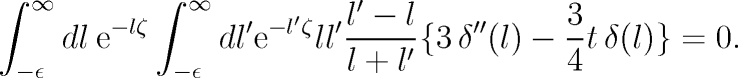

In [ ]:
y_combined['23be72ded29e9b4_basic.png']

In [ ]:
from PIL import Image, ImageDraw, ImageFont

def create_text_image(text_lines, font_size, color, image_path):
    # Load the default font
    font = ImageFont.load_default()

    # Calculate image size based on the number of lines and font size
    line_height = font_size * 2  # Space for each line
    image_width = 600  # Fixed width suitable for viewing
    image_height = 150  # Height based on the number of lines

    # Create a new blank image with white background
    image = Image.new('RGB', (image_width, image_height), "white")

    # Initialize the drawing context
    draw = ImageDraw.Draw(image)

    # Draw each line of text
    y = 5  # Start a little from the top
    for line in text_lines:
        text_width, text_height = draw.textsize(line, font=font)
        x = (image.width - text_width) / 2  # Center each line
        draw.text((x, y), line, font=font, fill=color)
        y += line_height  # Move to the next line

    # Save the image to a file
    image.save(image_path)

# Split the long LaTeX string into multiple lines
text_lines = [
    r"\[ \int_{-\epsilon}^{\infty} dl \: \mathrm{e}^{-l\zeta}\int_{-\epsilon}",
    r"\mathrm{e}^{-l^{\prime}\zeta} ll^{\prime}^{\infty} dl^{\prime}",
    r"\left\{ \frac{l^{\prime} - l}{l + l^{\prime}} \right\}\left",
    r"\{3 \, \delta^{\prime\prime}(l) - \frac{3}{4} t \, \delta(l)\right\} = 0 . \]"
]
font_size = 20  # Adjust as needed for text fit
color = "black"
image_path = "latex_writing.png"

create_text_image(text_lines, font_size, color, image_path)


<ipython-input-69-d6710502dde4>:21: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(line, font=font)
<ipython-input-69-d6710502dde4>:21: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(line, font=font)
<ipython-input-69-d6710502dde4>:21: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(line, font=font)
<ipython-input-69-d6710502dde4>:21: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(line, font=font)


In [ ]:
!ls

data  get_data.sh  output_text_image.png  sample_data
